In [53]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [54]:
import torch
import numpy as np
import h5py
import cv2
import PIL
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def save_eps(img,path):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    img = (img-img.min())/(img.max()-img.min())
    img = PIL.Image.fromarray((img*255).astype('uint8'))
    img.save(path,dpi=(300,300),mode='EPS')

In [56]:
folder_name = "./N2N_output_230917_wholeimg_on230414_onSEM2"
os.makedirs(folder_name, exist_ok=True)


In [57]:
path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_SNU_dataset_230414_1710x2990_aligned"
                 ]


In [58]:
def get_scene_number(filename):
    return str(int(filename.split("_")[1].split('-')[0]))
from glob import glob
test_img = ['F32_25']
def load_img_dict(target_x,target_y,debug=True):
    
    path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_SNU_dataset_230414_1710x2990_aligned"
                 ]
    # data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 

    unique_scene = np.unique(list(map(get_scene_number,os.listdir(path_list[0]))))
    print(unique_scene)
    # array of [01 ~ 42]
    f_num_list = ['F01','F32']
    test_image_idx = [img_name.split("_")[1] for img_name in test_img]
    img_dict = {}
    for data_path in path_list:
        print("=====",data_path, "=====")
        for f_num in f_num_list:
            img_dict[f_num] = {}
            f_number = int(f_num[1:])
            f_num = f"F{f_number:02d}"
            
            # img_list = sorted(os.listdir(data_path))
            img_list = sorted(glob(os.path.join(data_path,f"{f_num}_*")))
            img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
            
            for filename in sorted(img_list):
                filename = filename.split("/")[-1]
                img_path = os.path.join(data_path,filename)
                image_idx = int(filename.split("-")[1].split(".")[0])
                scene_num = get_scene_number(filename)
                    
                if scene_num not in test_image_idx :
                    continue
                if scene_num not in img_dict[f_num].keys():
                    img_dict[f_num][scene_num] = []
                filename = f"{f_num}_{scene_num}-{image_idx:02d}.png"
                img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) 
                # img_dict[set_num][f_num].append(img)
                # img = np.expand_dims(img,axis=0)
                img = np.expand_dims(img,axis=0) / 255.
                img_dict[f_num][scene_num].append(img)
                if debug is True:
                    print(img_path)
                    print(f_num,scene_num,img.shape)
                    print(len(img_dict[f_num][scene_num]))
                    break
    if debug is True:
        print(img_dict.keys())
        for f_num in img_dict.keys():
            for scene_num in img_dict[f_num].keys():
                print(f_num,scene_num,len(img_dict[f_num][scene_num]))
                print("   ",img_dict[f_num][scene_num][0].shape)
            
    print("====== load img_dict complete ======")
    return img_dict
                        

In [59]:
img_dict = load_img_dict('F01','F32',debug=False)

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
===== /home/hyunwoong/FBI-Denoiser/data/Samsung_SNU_dataset_230414_1710x2990_aligned =====
====== load img_dict complete ======


In [60]:
print(img_dict.keys())
for f_num in img_dict.keys():
    for scene_num in img_dict[f_num].keys():
        print(f_num,scene_num,len(img_dict[f_num][scene_num]))
        print("   ",np.array(img_dict[f_num][scene_num]).shape)

dict_keys(['F01', 'F32'])
F01 25 16
    (16, 1, 1710, 2990)
F32 25 1
    (1, 1, 1710, 2990)


(1280, 2990)


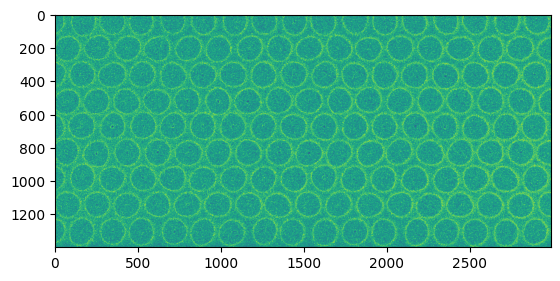

In [61]:
crop_width = 150
plt.imshow(img_dict['F01']['25'][0][0][crop_width+20:-crop_width+10])
top_crop = crop_width+20 + 120 
bottom_crop = crop_width-10
print(img_dict['F01']['25'][0][0][top_crop:-bottom_crop].shape)

1280 -> 5.0
1280
1536
2990 -> 11.6796875
2816
3072
(1280, 2816)


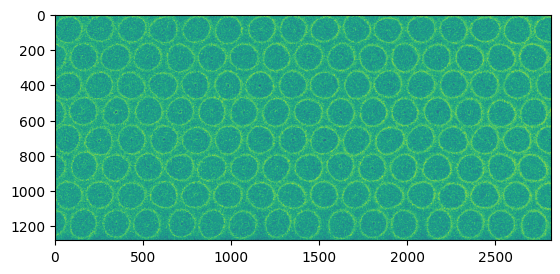

In [62]:
img_shape = img_dict['F01']['25'][0][0][top_crop:-bottom_crop].shape
for val in img_shape:
    print(val, '->',val / 256)
    print(val // 256 * 256)
    print(((val // 256)+1) * 256)
top_crop = 290
bottom_crop = 140
left_crop = 174
print(img_dict['F01']['25'][0][0][top_crop:-bottom_crop,:-left_crop].shape)
plt.imshow(img_dict['F01']['25'][0][0][top_crop:-bottom_crop,:-left_crop])

In [63]:

import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],loss = 'MSE_Affine',filter_keyword = ['median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = {}
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*{loss}*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list

In [78]:
!ls ../weights/230*_FBI_Net*F02*F08*

../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
../weights/230521_find_lambda_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F02_y_as_F08_l1_on_img_gradient_0.005_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_256.w
../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_10.w
../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_1.w
../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_2.w
../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_3.w
../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F02_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_4.w


In [85]:
gc.collect()
debug= False
partial_check = True
target_fbi_weight = [
    "../weights/230914_FBI_Net_EMSE_Affine_Grayscale_N2N_F01-F01_Samsung_EMSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_N2V_Grayscale_N2N_F01-F01_Samsung_N2V_layers_x17_filters_x64_cropsize_256.w",
    
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230920_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F32_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256_epoch15.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F32_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230920_FBI_Net_MSE_Grayscale_N2N_F01-F32_Samsung_MSE_layers_x17_filters_x64_cropsize_256.w",
    
    
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F02-F02_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F02-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    '../weights/230901_FBI_Net_Grayscale_N2N_F02-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F04-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230901_FBI_Net_Grayscale_N2N_F04-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230901_FBI_Net_Grayscale_N2N_F08-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",

    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine.w",
    
]


In [86]:


def parsing_weight_name(fbi_weight_dir):
    target_f = fbi_weight_dir.split("N2N_")[1].split("_Samsung")[0]
    target_x,target_y = target_f.split("-")
    info = "_".join(fbi_weight_dir.split("_")[1:]).split("_Grayscale")[0]
    arch = "_".join(info.split("_")[:2])
    if arch == 'FBI_Net':
        loss_func =  "".join(fbi_weight_dir.split("Samsung_")[1].split("_layers")[0])
    else :
        loss_func = "".join(fbi_weight_dir.split("Samsung_")[1].split(".w")[0])
    try: 
        add_info = fbi_weight_dir.split("cropsize_256_")[1].split(".w")[0]
    except :
        add_info = ""
    return target_x,target_y, arch, loss_func, add_info


In [87]:


for weight in target_fbi_weight:
    print(parsing_weight_name(weight))

('F01', 'F01', 'FBI_Net', 'EMSE_Affine', '')
('F01', 'F01', 'FBI_Net', 'N2V', '')
('F01', 'F01', 'FBI_Net', 'MSE_Affine', '')
('F01', 'F02', 'FBI_Net', 'MSE_Affine', '')
('F01', 'F04', 'FBI_Net', 'MSE_Affine', '')
('F01', 'F08', 'FBI_Net', 'MSE_Affine', '')
('F01', 'F32', 'FBI_Net', 'MSE_Affine', '')
('F01', 'F32', 'FBI_Net', 'MSE', '')
('F02', 'F02', 'FBI_Net', 'MSE_Affine', '')
('F02', 'F04', 'FBI_Net', 'MSE_Affine', '')
('F02', 'F08', 'FBI_Net', 'MSE_Affine', '')
('F04', 'F04', 'FBI_Net', 'MSE_Affine', '')
('F04', 'F08', 'FBI_Net', 'MSE_Affine', '')
('F08', 'F08', 'FBI_Net', 'MSE_Affine', '')
('F01', 'F01', 'NAFNet_light', 'MSE_Affine', '')
('F01', 'F02', 'NAFNet_light', 'MSE_Affine', '')
('F01', 'F04', 'NAFNet_light', 'MSE_Affine', '')
('F01', 'F08', 'NAFNet_light', 'MSE_Affine', '')


In [88]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'NAFNet_light'#'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [89]:

debug = False
imshow = False
metric = {}

In [90]:
from core.utils import get_PSNR,get_SSIM
skip = True
for weight_idx,fbi_weight_dir in enumerate(target_fbi_weight):
    if fbi_weight_dir != '../weights/230901_FBI_Net_Grayscale_N2N_F02-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w':
        continue
    print(fbi_weight_dir)
    target_x,target_y, arch, loss_func,add_info = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_{arch}"
    if loss_func != 'MSE_Affine':
        key += f"_{loss_func}"
    if add_info != "":
        key += f"_{add_info}"
    model_img_path = f"{folder_name}/{key}"
    os.makedirs(model_img_path,exist_ok=True)
    args.loss_function = loss_func
    args.model_type = arch
    if args.loss_function == 'EMSE_Affine':
        args.pge_weight_dir = "../weights/230914_PGE_Net_Noise_est_Grayscale_N2N_F01-F01_Samsung_Noise_est_cropsize_256_vst_MSE.w"
    else :
        args.pge_weight_dir = None
    print(f"========= {key}  & {loss_func }=========")
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    target_x = ['F01']
        
    if weight_idx == 0:
        metric['median_filter'] = {
            'PSNR' : [],
            'SSIM' : []
        }
        metric['raw'] = {
                'PSNR' : [],
                'SSIM' : []
            }
        # metric['bm3d'] = {
        #     'PSNR' : [],
        #     'SSIM' : []
        # }
    metric[key] = {
            'PSNR' : [],
            'SSIM' : []
        }
    for f_num in target_x:
        print(f_num)
        for scene_num in img_dict[f_num].keys():
        
            # print(f"Since F#, f_num : {f_num} Start")
            print(f"Denoising f_num : {f_num} scene num : {scene_num} Start")
            for idx,img in enumerate(img_dict[f_num][scene_num]):
                img = img[:,top_crop:-bottom_crop,:-left_crop]
                img = np.expand_dims(img, axis=0) # 1,1, 1710, 2990)
                clean_img = img_dict['F32'][scene_num][0]
                clean_img = clean_img[:,top_crop:-bottom_crop,:-left_crop][0]
                print(get_PSNR(clean_img,img[0][0]))
                print(f_num,scene_num,idx,img.shape)
                denoised_img = model.eval(img)[0][0]
                img = img[0][0]
                metric[key]['PSNR'].append(get_PSNR(clean_img,denoised_img))
                metric[key]['SSIM'].append(get_SSIM(clean_img,denoised_img))
                filename = f"{f_num}_{scene_num}-{idx:02d}.png"
                if os.path.exists(f"{model_img_path}/{filename}") is False:
                    print("imwrite : ",f"{model_img_path}/{filename}")
                    if type(denoised_img) == torch.Tensor:
                        denoised_img = denoised_img.cpu().detach().numpy()
                    cv2.imwrite(f"{model_img_path}/{filename}",denoised_img*255)
                if imshow is True and idx ==0 and scene_num == 0:
                    plt.figure(figsize=(20,20))
                    plt.title(f"{f_num}_{scene_num}-{idx:02d}.png\n{key}")
                    if type(denoised_img) == torch.Tensor:
                        denoised_img = denoised_img.cpu().detach().numpy()
                    plt.subplot(211)
                    plt.imshow(denoised_img)
                    plt.subplot(212)
                    plt.imshow(clean_img)
                    plt.pause(0.01)
                if weight_idx == 0:
                    metric['raw']['PSNR'].append(get_PSNR(clean_img,img))
                    metric['raw']['SSIM'].append(get_SSIM(clean_img,img))
                
                    medianfilterd_img = apply_median_filter_gpu_simple(img)[0][0]
                    median_psnr, median_ssim =  get_PSNR(clean_img,medianfilterd_img), get_SSIM(clean_img,medianfilterd_img)
                    metric['median_filter']['PSNR'].append(median_psnr)
                    metric['median_filter']['SSIM'].append(median_ssim)
                    
                    if scene_num == '1' and idx == 0:
                        filename = f"{folder_name}/F32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(clean_img,filename)
                        filename = f"{folder_name}/median_filter_f32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(medianfilterd_img,filename)
                if debug is True:
                    break
        if debug is True:
            break
        print(f"Denoising f_num : {f_num} scene_num : {scene_num} End")
    if debug is True:
        break
    del model
    gc.collect()


../weights/230901_FBI_Net_Grayscale_N2N_F02-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
========= F02-F08_FBI_Net  & MSE_Affine=========
F01
Denoising f_num : F01 scene num : 25 Start
12.119244250930413
F01 25 0 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414_onSEM2/F02-F08_FBI_Net/F01_25-00.png
12.146147154756843
F01 25 1 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414_onSEM2/F02-F08_FBI_Net/F01_25-01.png
12.147109632045012
F01 25 2 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414_onSEM2/F02-F08_FBI_Net/F01_25-02.png
12.15050143931785
F01 25 3 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414_onSEM2/F02-F08_FBI_Net/F01_25-03.png
12.152237530247378
F01 25 4 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414_onSEM2/F02-F08_FBI_Net/F01_25-04.png
12.13819766619767
F01 25 5 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414_onSEM2/F02-F08_FBI_Net/F01_25-05.png
12.

In [91]:
refined_metric = {}
for key in metric.keys():
    print(key)
    refined_metric[key] = {}
    for sub_key in metric[key].keys():     
        print(key,sub_key)
        if type(metric[key][sub_key]) == dict:
            metric[key][sub_key] = list(metric[key][sub_key].values())
        refined_metric[key][f'{sub_key}'] = np.mean(metric[key][sub_key])
        

import pandas as pd
refined_metric = pd.DataFrame(refined_metric)
refined_metric

F02-F08_FBI_Net
F02-F08_FBI_Net PSNR
F02-F08_FBI_Net SSIM


,F02-F08_FBI_Net
PSNR,19.627710
SSIM,0.211449


In [ ]:
refined_metric = {}
for key in metric.keys():
    print(key)
    refined_metric[key] = {}
    for sub_key in metric[key].keys():     
        print(key,sub_key)
        if type(metric[key][sub_key]) == dict:
            metric[key][sub_key] = list(metric[key][sub_key].values())
        refined_metric[key][f'{sub_key}'] = np.mean(metric[key][sub_key])
        

import pandas as pd
refined_metric = pd.DataFrame(refined_metric)
refined_metric

median_filter
median_filter PSNR
median_filter SSIM
raw
raw PSNR
raw SSIM
F01-F01_FBI_Net_EMSE_Affine
F01-F01_FBI_Net_EMSE_Affine PSNR
F01-F01_FBI_Net_EMSE_Affine SSIM
F01-F01_FBI_Net_N2V
F01-F01_FBI_Net_N2V PSNR
F01-F01_FBI_Net_N2V SSIM
F01-F01_FBI_Net
F01-F01_FBI_Net PSNR
F01-F01_FBI_Net SSIM
F01-F02_FBI_Net
F01-F02_FBI_Net PSNR
F01-F02_FBI_Net SSIM
F01-F04_FBI_Net
F01-F04_FBI_Net PSNR
F01-F04_FBI_Net SSIM
F01-F08_FBI_Net
F01-F08_FBI_Net PSNR
F01-F08_FBI_Net SSIM
F01-F32_FBI_Net
F01-F32_FBI_Net PSNR
F01-F32_FBI_Net SSIM
F01-F32_FBI_Net_MSE
F01-F32_FBI_Net_MSE PSNR
F01-F32_FBI_Net_MSE SSIM
F02-F02_FBI_Net
F02-F02_FBI_Net PSNR
F02-F02_FBI_Net SSIM
F02-F04_FBI_Net
F02-F04_FBI_Net PSNR
F02-F04_FBI_Net SSIM
F04-F04_FBI_Net
F04-F04_FBI_Net PSNR
F04-F04_FBI_Net SSIM
F04-F08_FBI_Net
F04-F08_FBI_Net PSNR
F04-F08_FBI_Net SSIM
F08-F08_FBI_Net
F08-F08_FBI_Net PSNR
F08-F08_FBI_Net SSIM
F01-F01_NAFNet_light
F01-F01_NAFNet_light PSNR
F01-F01_NAFNet_light SSIM
F01-F02_NAFNet_light
F01-F02_NAFNet_lig

,median_filter,raw,F01-F01_FBI_Net_EMSE_Affine,F01-F01_FBI_Net_N2V,F01-F01_FBI_Net,F01-F02_FBI_Net,F01-F04_FBI_Net,F01-F08_FBI_Net,F01-F32_FBI_Net,F01-F32_FBI_Net_MSE,F02-F02_FBI_Net,F02-F04_FBI_Net,F04-F04_FBI_Net,F04-F08_FBI_Net,F08-F08_FBI_Net,F01-F01_NAFNet_light,F01-F02_NAFNet_light,F01-F04_NAFNet_light,F01-F08_NAFNet_light
PSNR,19.411010,12.135794,16.339977,16.384937,19.578969,19.613738,19.658977,19.664937,21.244893,21.317739,19.561023,19.622695,19.325570,19.198914,18.443729,19.632567,19.697170,19.580507,19.643712
SSIM,0.193428,0.032775,0.089597,0.088797,0.210217,0.211339,0.212519,0.211230,0.238766,0.239521,0.212082,0.211423,0.202796,0.204099,0.180367,0.210862,0.213042,0.212602,0.211599


In [81]:
refined_metric.T.to_csv(f"{folder_name}/metric_whole_230414_on_SEM2_tmp.csv")


In [76]:
refined_metric.T.to_csv(f"{folder_name}/metric_whole_230414_on_SEM2.csv")


In [ ]:
from knockknock import telegram_sender
@telegram_sender(token='1531143270:AAFTord-4Bi370ohc39wGyYhjGi7_VjZTwU', chat_id=1597147353)
def denoising_end():
    print("Denoising End")
denoising_end()
!date

Denoising End
Fri Sep 29 16:27:35 UTC 2023
